# Práctica 5 : Regresión lineal regularizada, sesgo y varianza

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Regresión Lineal Regularizada

In [63]:
#########
# MUY IMPORTANTE HACER RAVEL PARA PASAR DE (12,) a (12). SI USAS (12,) HACE BROADCASTING
########

def cargaDatos(file = 'ex5data1.mat'):
    m = loadmat(file)
    x_train = m['X']
    y_train = m['y'].ravel()
    x_test = m['Xtest']
    y_test = m['ytest'].ravel()
    x_val = m['Xval']
    y_val = m['yval'].ravel()
    train = [x_train, y_train]
    test = [x_test, y_test]
    val = [x_val, y_val]
    return train, test, val

In [331]:
def coste_reg(T, X, Y, Lambda):
    coste = (1/(2* X.shape[0]))* ((np.dot(X,T)-Y)**2).sum() + (Lambda/(2*X.shape[0])) / (T[1:]**2).sum()
    return coste

In [332]:
def gradiente_reg(T, X, Y, Lambda):
    H = np.dot(X,T)
    D = H - Y
    G = np.dot(X.T, D)
    G = G / X.shape[0]
    G[1:] += (T[1:] * (Lambda / X.shape[0]))
    return G

In [333]:
def main1():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1].ravel()
    m = X.shape[0]
    X = np.hstack([np.ones( [m, 1 ] ) , X ] )
    T = np.ones((1,X.shape[1])).ravel()
    grad = gradiente_reg(T,X,Y,1)
    c = coste_reg(T,X,Y,1)
    print(c)
    print(grad)

In [334]:
main1()

303.9931922202643
[-15.30301567 598.25074417]


In [335]:
def costeygradienteReg(Theta,X,Y,Lambda):

    Xaux = np.hstack([np.ones((X.shape[0], 1)), X])
    coste = coste_reg(Theta,Xaux,Y,Lambda)
    gradiente = gradiente_reg(Theta,Xaux,Y,Lambda)
    return coste,gradiente

In [336]:
def optimizar(X,Y,Lambda):
    T = np.ones((X.shape[0],)).ravel()
    result = opt.minimize(costeygradienteReg,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [337]:
def main2():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    print(r)

In [349]:
main2()

ValueError: shapes (12,2) and (12,) not aligned: 2 (dim 1) != 12 (dim 0)

In [270]:
def pintarDatos():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    
    plt.figure()
    plt.plot(X,Y,"x")
    min_x = min(X)
    max_x = max(X)
    min_y = r[0] + r[1] * min_x
    max_y = r[0] + r[1] * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

In [271]:
pintarDatos()

ValueError: shapes (12,2) and (12,) not aligned: 2 (dim 1) != 12 (dim 0)

## Curvas de Aprendizaje

In [245]:
def curvaAprendizaje():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    
    Xval = vl[0]
    Xval = np.hstack([np.ones((Xval.shape[0], 1)), Xval])
    Yval = vl[1]
    
    erroresT = np.zeros((X.shape[0],))
    erroresV = np.zeros((X.shape[0],))
    ejeX = np.zeros((X.shape[0],))
    for j in range(1,X.shape[0]):
        ejeX[j] = j
        Xaux = X[0:j].ravel()
        Yaux = Y[0:j]
        r = optimizar(Xaux,Yaux,0)
        Xaux2 = np.hstack([np.ones((j, 1)), Xaux])
        erroresT[j] += coste_reg(r,Xaux2,Y,0)
        erroresV[j] += coste_reg(r,Xval,Yval,0)
    
    plt.figure()
    plt.plot(ejeX[1:], erroresT[1:], 'b', label = "Entrenamiento")
    plt.plot(ejeX[1:], erroresV[1:], 'r', label = "Validacion")
    plt.xlabel("Numero de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

In [246]:
curvaAprendizaje()

IndexError: tuple index out of range

## Regresión Polinomial

In [17]:
def costeygradienteReg2(Theta,X,Y,Lambda):
    coste = coste_reg(Theta,X,Y,Lambda)
    gradiente = gradiente_reg(Theta,X,Y,Lambda)
    return coste,gradiente

In [18]:
def optimizar2(X,Y,Lambda):
    T = np.ones((X.shape[1],))
    result = opt.minimize(costeygradienteReg2,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [19]:
def generaPolinomio(X,g):
    p = PolynomialFeatures(g)
    X2 = p.fit_transform(X)
    return X2

In [20]:
def normalizar(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return(X_norm, mu, sigma)

In [21]:
def main3():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    Xpol = generaPolinomio(X,8)
    Xpoln , mu, sigma = normalizar(Xpol[:, 1:])
    ones = np.ones((Xpoln.shape[0],1))
    Xpoln = np.hstack([ones, Xpoln])
    
    T = optimizar2(Xpoln, Y, 0)
    
    Xvalues = np.arange(X.min()-5 , X.max()+5, 0.05)
    # Para pasar de 1D array a 2D array. Lo hago porque salia un error que me decía que lo hiciera
    Xvalues = Xvalues.reshape(-1, 1)
    Xpolvalues = generaPolinomio(Xvalues,8)
    Xpolnvalues = (Xpolvalues[:,1:] - mu) / sigma
    ones2 = np.ones((Xpolnvalues.shape[0], 1))
    Xpolnvalues = np.hstack([ones2, Xpolnvalues])
    
    Ypolvalues  = np.dot(Xpolnvalues,T)
    
    ax=plt.gca()
    ax.axis([X.min()-5,X.max()+5,Y.min()-10,Y.max()+5])
    plt.plot(X,Y, "x", color = 'red')
    plt.plot(Xvalues, Ypolvalues, '-b')

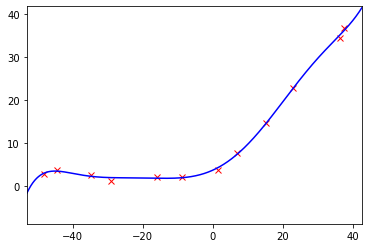

In [23]:
main3()

## Curva de Aprendizaje

In [129]:
def normalizarconScaler(X):
    scaler = StandardScaler()
    scaler.fit(X)
    mu = scaler.mean_.ravel()
    sigma = scaler.scale_.ravel()
    Y = scaler.transform(X)
    return Y,mu,sigma

In [208]:
def curvaAprendizaje2():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]   
    
    Xpol = generaPolinomio(X,8)
    Xpoln, mu, sigma = normalizarconScaler(Xpol)
    print(mu.shape)
    print(sigma.shape)
    
    Xval = vl[0]
    Yval = vl[1]
    
    Xval = generaPolinomio(Xval,8)
    Xvalpn = (Xval - mu) / sigma
    Xvalpn = np.hstack([np.ones((Xval.shape[0],1)), Xvalpn[:,1:]])
    
    
    ejeXval= np.zeros(X.shape[0]-1)
    errTest= np.zeros(X.shape[0]-1)
    errVal = np.zeros(X.shape[0]-1)
     
    for j in range(1, X.shape[0]):
        T = optimizar2(Xpoln[:j],Y[:j],0)
        coste_train = coste_reg(T,Xpoln[:j],Y[:j],0)
        coste_val = coste_reg(T,Xvalpn,Yval,0)
        
        print("para j = {} me sale costetrain = {} y costeval = {}".format(j,coste_train,coste_val))
        
        ejeXval[j-1] = j
        errTest[j-1] = coste_train
        errVal[j-1] = coste_val
        
    plt.figure()
    plt.plot(ejeXval, errTest, 'b', label = "Entrenamiento")
    plt.plot(ejeXval, errVal, 'r', label = "Validacion")
    plt.xlabel("Numero de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

(9,)
(9,)
para j = 1 me sale costetrain = 8.755293039644982e-19 y costeval = 125.63651774158006
para j = 2 me sale costetrain = 3.9453302220878667e-17 y costeval = 130.85075294241165
para j = 3 me sale costetrain = 3.0671383680808394e-18 y costeval = 315.6699992955963
para j = 4 me sale costetrain = 8.98658777809919e-16 y costeval = 339.30384411387274
para j = 5 me sale costetrain = 8.456882865137492e-12 y costeval = 145.49073865596338
para j = 6 me sale costetrain = 1.0701421662726417e-07 y costeval = 862.9593656838814
para j = 7 me sale costetrain = 2.5294939435917633e-06 y costeval = 1444.3291880210288
para j = 8 me sale costetrain = 25.627558748486578 y costeval = 12783.357082599956
para j = 9 me sale costetrain = 28.82409537884185 y costeval = 2602.1978660479745
para j = 10 me sale costetrain = 47.00447395994766 y costeval = 209.71502342501307
para j = 11 me sale costetrain = 41.703429821288196 y costeval = 587.672822414303


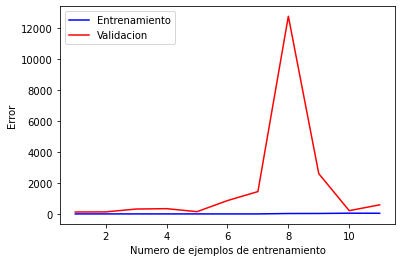

In [209]:
curvaAprendizaje2()